## Motorcycle CNN classifier

The project was created to demonstrate the skills of creating and deploying a convolutional neural network for motorcycle classification. The dataset consists of pictures of different classes of motorcycles collected from various search engines. The notebook also contains screenshots of tensorboards to demonstrate graphs, to recreate these boards in the browser, you can use the logs from the 'runs' folder.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

### Data EDA

Defining a exploring fucntion

In [5]:
from basic_image_eda import BasicImageEDA

def view_dir(dir):
    BasicImageEDA.explore(dir, extensions=['jpg', 'jpeg'], dimension_plot=True, channel_hist=True)

Now let's check each class of motorcycles by defined function


found 600 images.
Using 6 threads. (max:6)



  0%|          | 0/600 [00:00<?, ?it/s]

100%|██████████| 600/600 [00:06<00:00, 93.75it/s] 



*--------------------------------------------------------------------------------------*
number of images                         |  600

dtype                                    |  uint8
channels                                 |  [3]
extensions                               |  ['jpg', 'JPG', 'jpeg']

min height                               |  140
max height                               |  600
mean height                              |  229.50833333333333
median height                            |  224

min width                                |  200
max width                                |  900
mean width                               |  328.4683333333333
median width                             |  320

mean height/width ratio                  |  0.6987228601437988
median height/width ratio                |  0.7
recommended input size(by mean)          |  [232 328] (h x w, multiples of 8)
recommended input size(by mean)          |  [224 336] (h x w, multiples of 16)
recommended 

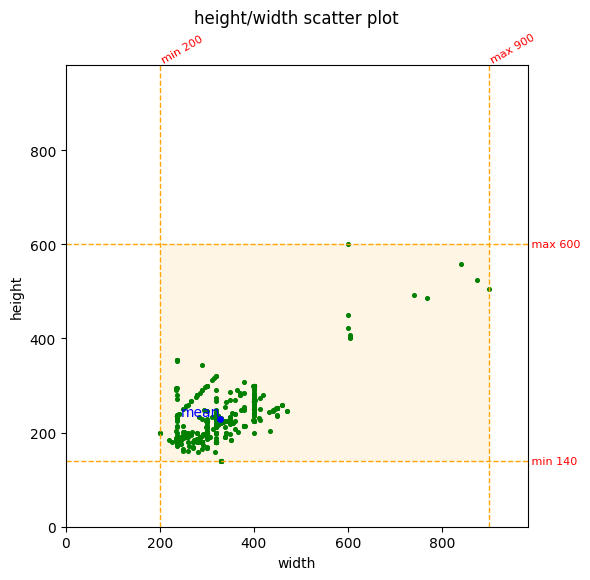

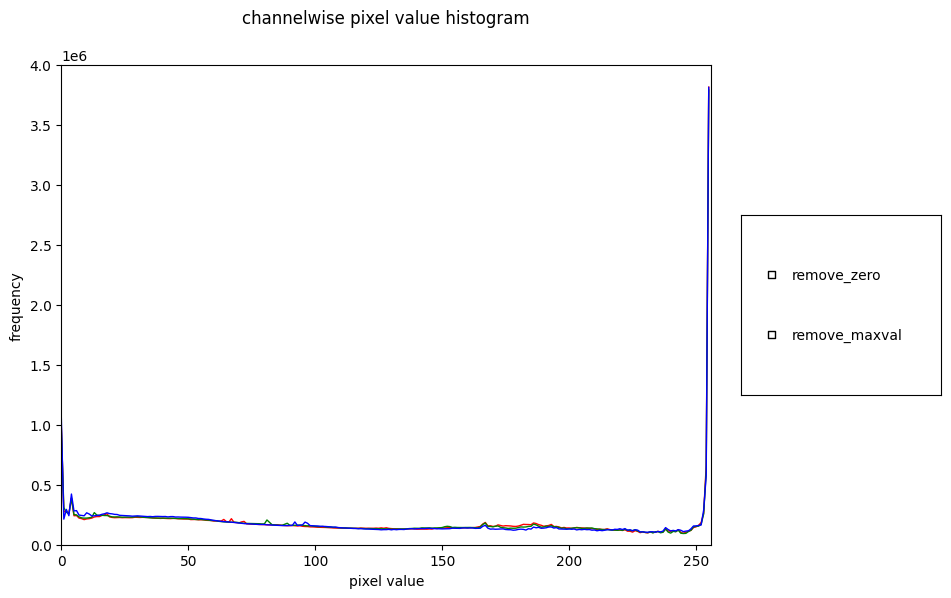

In [6]:
view_dir('Dataset/Train/city')


found 600 images.
Using 6 threads. (max:6)



  0%|          | 0/600 [00:00<?, ?it/s]

100%|██████████| 600/600 [00:14<00:00, 40.68it/s]



*--------------------------------------------------------------------------------------*
number of images                         |  600

dtype                                    |  uint8
channels                                 |  [3]
extensions                               |  ['jpg', 'JPG', 'jpeg']

min height                               |  240
max height                               |  747
mean height                              |  451.64666666666665
median height                            |  450

min width                                |  384
max width                                |  1030
mean width                               |  627.9516666666667
median width                             |  640

mean height/width ratio                  |  0.7192379455956004
median height/width ratio                |  0.703125
recommended input size(by mean)          |  [448 624] (h x w, multiples of 8)
recommended input size(by mean)          |  [448 624] (h x w, multiples of 16)
recomm

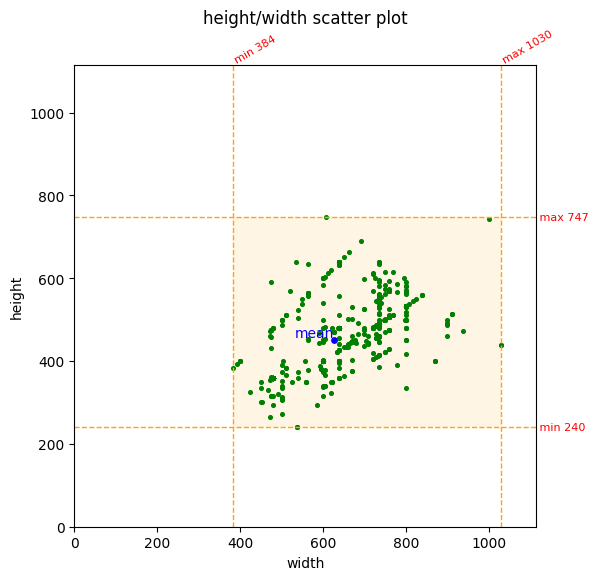

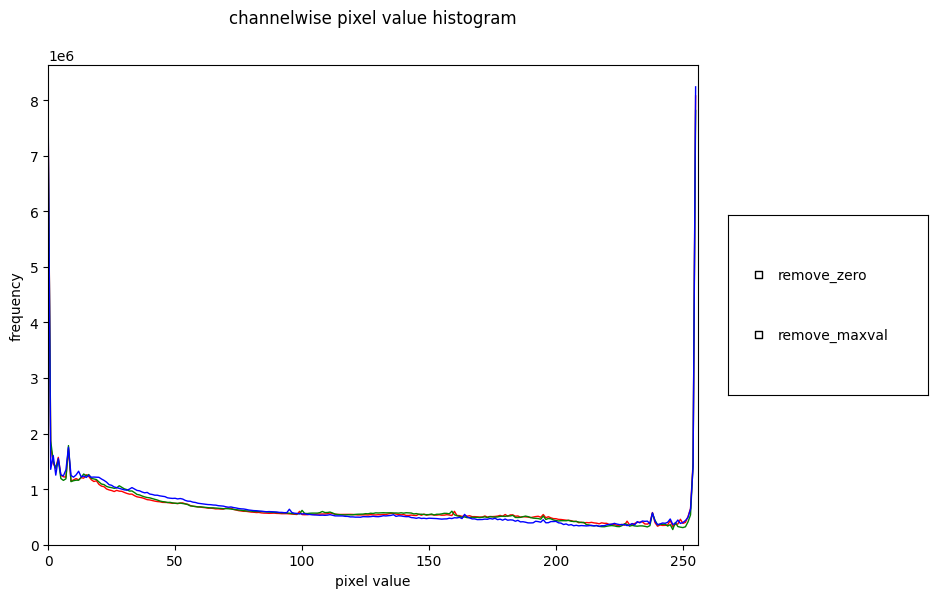

In [7]:
view_dir('Dataset/Train/sport')


found 600 images.
Using 6 threads. (max:6)



  0%|          | 0/600 [00:00<?, ?it/s]

100%|██████████| 600/600 [00:13<00:00, 43.30it/s]



*--------------------------------------------------------------------------------------*
number of images                         |  600

dtype                                    |  uint8
channels                                 |  [3]
extensions                               |  ['jpg', 'jpeg']

min height                               |  140
max height                               |  683
mean height                              |  419.5416666666667
median height                            |  428

min width                                |  200
max width                                |  1024
mean width                               |  616.1966666666667
median width                             |  640

mean height/width ratio                  |  0.6808567610989997
median height/width ratio                |  0.66875
recommended input size(by mean)          |  [416 616] (h x w, multiples of 8)
recommended input size(by mean)          |  [416 624] (h x w, multiples of 16)
recommended inp

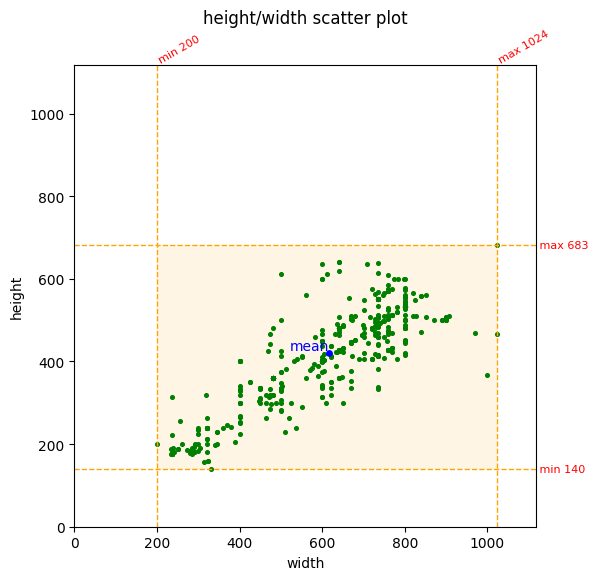

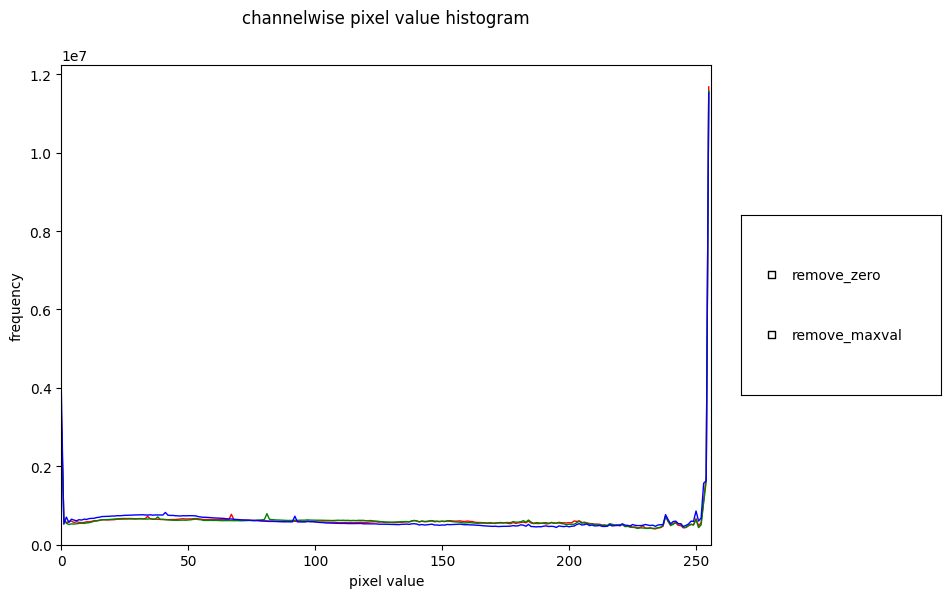

In [8]:
view_dir('Dataset/Train/tourist')

- From these graphs I can conclude that the majotity of pictures lay within the small sizes like ~(200-800)x~(200-800) with around 0.69 height/width ratio

#### Checking the class balance

<BarContainer object of 3 artists>

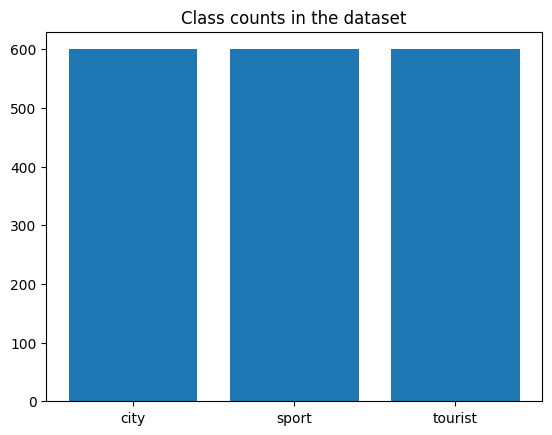

In [9]:
import os

class_counts = {}
for cls in ['city', 'sport', 'tourist']:
    dir_path = f'Dataset/Train/{cls}'
    count = 0

    for path in os.listdir(dir_path):
        if os.path.isfile(os.path.join(dir_path, path)):
            count += 1
    class_counts[cls] = count
plt.title('Class counts in the dataset')
plt.bar(class_counts.keys(), class_counts.values())

There is no imbalance in classes in this dataset!

### Preparing the images for training and visualizing some of them

In [10]:
import torchvision
from torchvision import transforms

def get_images(image_directory, resize=(224, 224)):
    train_transform = transforms.Compose([
        transforms.Resize(resize),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    test_transform = transforms.Compose([
        transforms.Resize(resize),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    train_dataset = torchvision.datasets.ImageFolder(
        root=f'{image_directory}/Train',
        transform=train_transform
    )
    test_dataset = torchvision.datasets.ImageFolder(
        root=f'{image_directory}/Test',
        transform=test_transform
    )

    return train_dataset, test_dataset


def visualize_random_pictures(directory):
    fig = plt.figure(figsize=(10, 10))
    rows, columns = 5, 5
    train_dataset = torchvision.datasets.ImageFolder(root=f'{directory}/Train')
    rand_indeces = np.random.randint(low=0, high=len(train_dataset), size=(rows*columns,))

    images = []
    labels = []

    for i in rand_indeces:
        img, class_ = train_dataset[i]
        images.append(img)
        labels.append(train_dataset.classes[class_])

    # visualize these random images
    for i in range(1, columns*rows+1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(images[i-1])
        plt.xticks([])
        plt.yticks([])
        plt.title(f"{labels[i-1]}")
    plt.show()

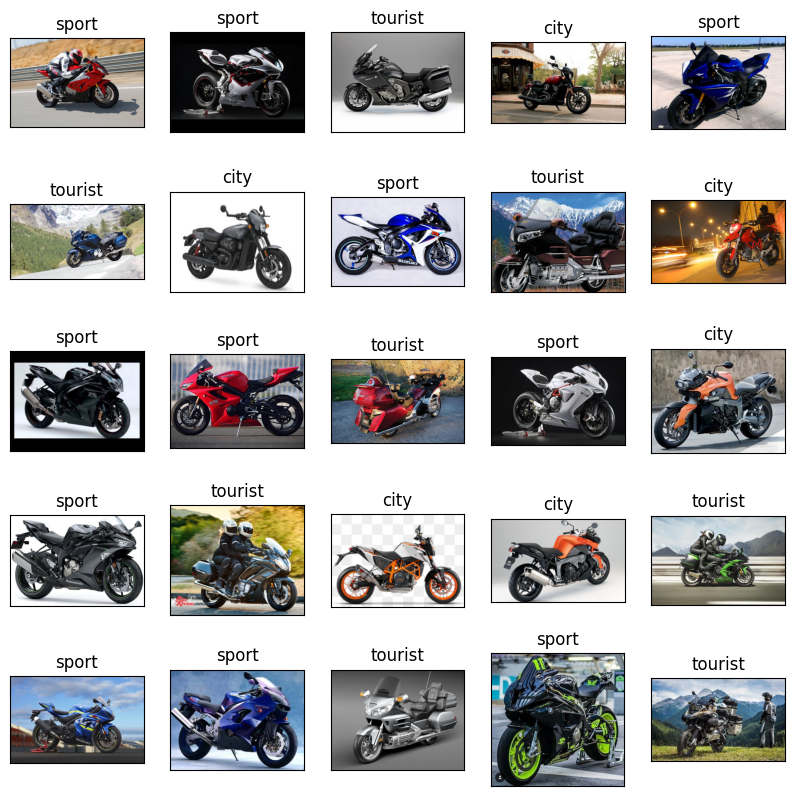

In [11]:
visualize_random_pictures('Dataset')

In [18]:
from torch.utils.data import DataLoader

train_imgs, test_imgs = get_images('Dataset')
train_loader = DataLoader(train_imgs, batch_size=128, shuffle=True)
test_loader = DataLoader(test_imgs, batch_size=128, shuffle=False)

### Choosing the metric

- As the dataset is balanced I am choosing accuracy and classification report (precision, recall and f1-score) as the target metrics

### Creating train and test fucntions for future models

In [13]:
import time as t
import copy
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def train(model, dataloaders, criterion, optimizer, n_epochs, device, tb_writer):
    since = t.time()

    for epoch in range(n_epochs):
        print('Epoch {}/{}'.format(epoch, n_epochs - 1))
        print('-' * 20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    y_pred_proba = torch.softmax(outputs, dim=1)
                    y_pred = y_pred_proba.argmax(dim=1)
                    loss = criterion(outputs, labels)

                    tb_writer.add_scalar(f'Loss ({phase})', loss, epoch)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(y_pred == labels)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            tb_writer.add_scalar('Accuracy', epoch_acc, epoch)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    time_elapsed = t.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return model

def get_model_statistics(model, dataset_path, device):
    _, test_data = get_images(dataset_path)
    test_data_loader = DataLoader(test_data, batch_size=10)

    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for X, y in test_data_loader:
            X = X.to(device)
            y = y.to(device)
            
            outputs = model(X)
            y_pred += torch.softmax(outputs, dim=1).argmax(dim=1).to('cpu').tolist()
            y_true += y.to('cpu').tolist()

    y_pred = [test_data.classes[i] for i in y_pred]
    y_true = [test_data.classes[i] for i in y_true]
    print(classification_report(y_true, y_pred))

    matrix = confusion_matrix(y_true, y_pred)
    
    cm_display = ConfusionMatrixDisplay(matrix, display_labels=test_data.classes)
    cm_display.plot()

### Creating the baseline CNN as a start point

In [11]:
from torch import nn

class Baseline(nn.Module):
    def __init__(self):
        super().__init__()

        self.get_features = nn.Sequential( # Shape: [batch_size, 3, 224, 224]
            nn.Conv2d(3, 16, 3, 1), # Shape: [batch_size, 64, 222, 222]
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2), # Shape: [batch_size, 64, 111, 111]

            nn.Conv2d(16, 32, 3, 1), # Shape: [batch_size, 64, 109, 109]
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 32, 3, 1), # Shape: [batch_size, 64, 107, 107]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2), # Shape: [batch_size, 64, 54, 54]

            nn.Conv2d(32, 32, 3, 1), # Shape: [batch_size, 32, 52, 52]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2), # Shape: [batch_size, 32, 26, 26]

            nn.Dropout(.25),
            nn.Flatten(1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(20000, 10816),
            nn.BatchNorm1d(10816),
            nn.ReLU(),

            nn.Linear(10816, 10816),
            nn.BatchNorm1d(10816),
            nn.ReLU(),
            
            nn.Dropout(.2),
            
            nn.Linear(10816, 3)
        )

    def forward(self, x):
        return self.classifier(self.get_features(x))

In [12]:
from torch import optim
from torch.utils.tensorboard import SummaryWriter

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Baseline().to(device)

dataloaders_dict = {
    "train": train_loader,
    "val": test_loader,
}
optimizer = optim.SGD(params=model.parameters(), lr=0.001, momentum=.9)
criterion = nn.CrossEntropyLoss()
epochs = 100

loss_writer = SummaryWriter()
model = train(model, dataloaders_dict, criterion, optimizer, epochs, device, tb_writer=loss_writer)

Epoch 0/99
--------------------
train Loss: 10.4860 Acc: 0.3689
val Loss: 12.2116 Acc: 0.3867
Epoch 1/99
--------------------
train Loss: 12.1184 Acc: 0.3306
val Loss: 7.1311 Acc: 0.3400
Epoch 2/99
--------------------
train Loss: 13.8027 Acc: 0.3494
val Loss: 9.7829 Acc: 0.3333
Epoch 3/99
--------------------
train Loss: 11.7167 Acc: 0.3522
val Loss: 5.3590 Acc: 0.3833
Epoch 4/99
--------------------
train Loss: 10.5032 Acc: 0.3611
val Loss: 6.9131 Acc: 0.3467
Epoch 5/99
--------------------
train Loss: 11.8230 Acc: 0.3600
val Loss: 7.0409 Acc: 0.4367
Epoch 6/99
--------------------
train Loss: 11.1037 Acc: 0.3450
val Loss: 7.4160 Acc: 0.4433
Epoch 7/99
--------------------
train Loss: 12.0323 Acc: 0.3472
val Loss: 9.3598 Acc: 0.3967
Epoch 8/99
--------------------
train Loss: 11.1535 Acc: 0.3644
val Loss: 5.0902 Acc: 0.3467
Epoch 9/99
--------------------
train Loss: 11.1503 Acc: 0.3544
val Loss: 8.6098 Acc: 0.3500
Epoch 10/99
--------------------
train Loss: 10.3168 Acc: 0.3406
val 

In [ ]:
from tensorboard import notebook

notebook.display(port=6006, height=500)

![](tensorboard_imgs/bs_acc.png)

![](tensorboard_imgs/bs_loss_train.png)

![](tensorboard_imgs/bs_loss_val.png)

              precision    recall  f1-score   support

        city       0.48      0.46      0.47       100
       sport       0.59      0.48      0.53       100
     tourist       0.51      0.62      0.56       100

    accuracy                           0.52       300
   macro avg       0.52      0.52      0.52       300
weighted avg       0.52      0.52      0.52       300



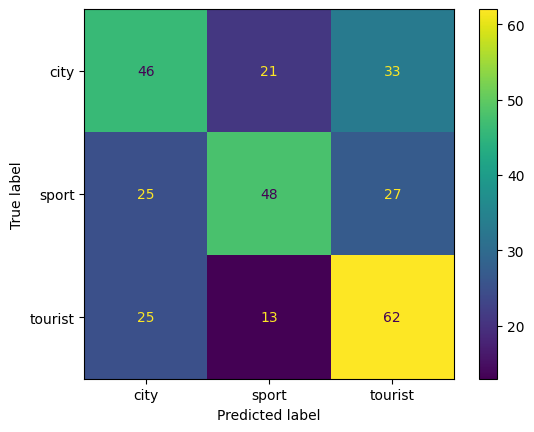

In [22]:
get_model_statistics(model.to('cuda'), 'Dataset', device)

Baseline gives around 50% of accuracy at the last epochs, it of course could be better with a bigger amount of epochs, but even this took more than two hours to train. So to improve accuracy and other metrics from a classification report I'll use pretrained model and finetune it.

### Finetuning the pretrained model

In [19]:
from torch import nn
from torch import optim
from torchvision import models

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = models.convnext_base(weights=models.ConvNeXt_Base_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.classifier[2].in_features # Getting the number of input features for the linear layer
model.classifier = nn.Sequential(
    nn.Flatten(1),

    nn.Linear(num_ftrs, num_ftrs),
    nn.BatchNorm1d(num_ftrs),
    nn.ReLU(),
    nn.Dropout(.2),

    nn.Linear(num_ftrs, 3) # The result number of classes we need to predict is 3.
)

model = model.to(device)

dataloaders_dict = {
    "train": train_loader,
    "val": test_loader,
}
optimizer = optim.SGD(params=model.parameters(), lr=.01, momentum=.9)
criterion = nn.CrossEntropyLoss()
epochs = 100

loss_writer = SummaryWriter()
model = train(model, dataloaders_dict, criterion, optimizer, epochs, device, tb_writer=loss_writer)

Epoch 0/99
--------------------
train Loss: 0.6301 Acc: 0.7333
val Loss: 0.7224 Acc: 0.8267
Epoch 1/99
--------------------
train Loss: 0.2438 Acc: 0.9083
val Loss: 0.3591 Acc: 0.9067
Epoch 2/99
--------------------
train Loss: 0.1913 Acc: 0.9344
val Loss: 0.4439 Acc: 0.8433
Epoch 3/99
--------------------
train Loss: 0.1981 Acc: 0.9250
val Loss: 0.4546 Acc: 0.8267
Epoch 4/99
--------------------
train Loss: 0.1718 Acc: 0.9389
val Loss: 0.2965 Acc: 0.9000
Epoch 5/99
--------------------
train Loss: 0.1631 Acc: 0.9406
val Loss: 0.2790 Acc: 0.9167
Epoch 6/99
--------------------
train Loss: 0.1477 Acc: 0.9428
val Loss: 0.3222 Acc: 0.8933
Epoch 7/99
--------------------
train Loss: 0.1215 Acc: 0.9594
val Loss: 0.4109 Acc: 0.8733
Epoch 8/99
--------------------
train Loss: 0.1981 Acc: 0.9267
val Loss: 0.3614 Acc: 0.9067
Epoch 9/99
--------------------
train Loss: 0.1573 Acc: 0.9444
val Loss: 0.4060 Acc: 0.9033
Epoch 10/99
--------------------
train Loss: 0.1531 Acc: 0.9511
val Loss: 0.3782

In [ ]:
notebook.display(port=6006, height=500) # launch tensorboard

![](tensorboard_imgs/ft_acc.png)

![](tensorboard_imgs/ft_loss_train.png)

![](tensorboard_imgs/ft_loss_val.png)

              precision    recall  f1-score   support

        city       0.85      0.94      0.89       100
       sport       0.98      0.87      0.92       100
     tourist       0.96      0.96      0.96       100

    accuracy                           0.92       300
   macro avg       0.93      0.92      0.92       300
weighted avg       0.93      0.92      0.92       300



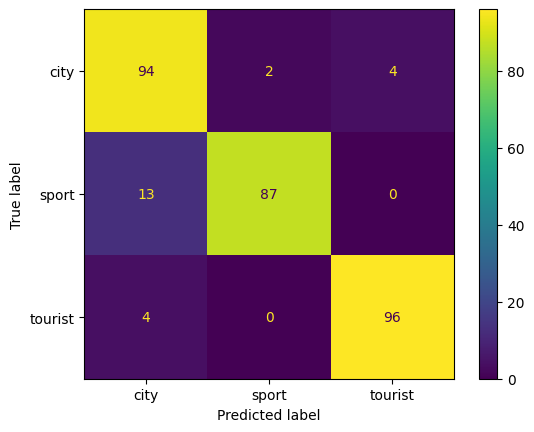

In [20]:
get_model_statistics(model, 'Dataset', device)

In [25]:
torch.save(model.state_dict(), 'ConvNeXt_Base_finetuned.pth')

Finetuned ConvNeXT_base gives an accuracy of around 93% correctly predicting all classes of motorcycles. From the confusion matrix I can conclude that model can possibly missclassify sportbikes as city ones, but other classes have a pretty good accuracies.